In [13]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from copy import deepcopy

In [14]:
tabela = pd.read_csv("telecom_users.csv")

In [15]:
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        rand = round(random.uniform(0.1, 0.9),1) #número aleatorio com uma casa decimal entre 0 e 0.9
        chromosome = np.ones(n_feat,dtype=bool)
        chromosome[:int(rand*n_feat)]=False #primeiros rand % elementos são convertidos para false, por exemplo, se rand = 0.3, 30% das colunas não estarão presentes para o individuo
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

In [16]:
def fitness_score(population,clf):
    scores = []
    for chromosome in population:
        clf.fit(X_train.iloc[:,chromosome],y_train)
        predictions = clf.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    #inds = np.argsort(scores)
    return list(scores), list(population)

In [17]:
def tournmentSelection(popu, score, n_parents):
    new_pop = []
    for i in range(n_parents):
        x1 = score[random.randint(0,len(score)-1)]
        x2 = score[random.randint(0,len(score)-1)]
        if x1 == x2:
            one_or_two = random.randint(0,1)
            if one_or_two == 0:
                winner = x1
            else:
                winner = x2
        elif x1 > x2:
            #print(score.index(x1))
            winner = score.index(x1)

        else:
            #print(score.index(x1))
            winner = score.index(x2)
        new_pop.append(deepcopy(popu[int(winner)]))
    return(new_pop)

In [18]:
def crossover(pop_after_sel, n_feat):
    population_nextgen = []
    child = []
    flat_child = []
    for i in range(len(pop_after_sel)):
        dadIndex = random.randint(0,len(pop_after_sel)-1)
        momIndex = random.randint(0,len(pop_after_sel)-1)
        while(dadIndex == momIndex):
            dadIndex = random.randint(0,len(pop_after_sel)-1)
            momIndex = random.randint(0,len(pop_after_sel)-1)
        dad = pop_after_sel[dadIndex]
        mom = pop_after_sel[momIndex]
        child.clear()
        flat_child.clear()
        qtdCortes = random.randint(1,n_feat-1) #gera o número de cortes que serão usados 
        indexCortes = np.random.choice(np.arange(1, n_feat), replace=False, size=qtdCortes) #gera um vetor de qtdCortes posições contendo os indices que serão utilizados para os corte
        indexCortes = np.sort(indexCortes) #organiza o vetor de indices do menor para o maior
        for j in range(len(indexCortes)):
            #se o indice do corte for par, tirar os genes do pai. A retirada dos genes funciona da seguinte forma: suponha que o filho no momento tenha 0 genes, 
            #os genes retirados do pai serão os genes da posição 0 até a posição informada pelo vetor de indices de corte na posição j
            # Agora, suponha que o filho já possu 5 genes, os genes retirados do pai serão aqueles da posição 5 do pai até a posição informada pelo vetor de indices de corte na posição j
            #print("Cromossomo 1",flat_child )
            #print("Vec acces", len(flat_child), indexCortes[j])
            if j%2 ==0: 
                child.append(dad[len(flat_child):indexCortes[j]])
                #print("Pai", dad)
            else:
                child.append(mom[len(flat_child):indexCortes[j]])
                #print("Mae", mom)
            flat_child = [item for sublist in child for item in sublist]
            #print("Cromossomo 2",flat_child )
        if j%2 ==0: 
            child.append(dad[len(flat_child):n_feat])
            #print("Pai", dad)
        else:
            child.append(mom[len(flat_child):n_feat])
            #print("Mae", mom)
        flat_child = [item for sublist in child for item in sublist]
        #print("Flatzada", flat_child)
        if (1 not in flat_child):
            flat_child[random.randint(0, n_feat-1)] =True
        #child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
        population_nextgen.append(deepcopy(flat_child))
        second_child = list((not gene for gene in flat_child))
        if (1 not in second_child):
            second_child[random.randint(0, n_feat-1)] =True
        population_nextgen.append(deepcopy(second_child))
    return population_nextgen

In [19]:
def mutation(pop_after_cross,mutation_rate):
    population_nextgen = []
    for i in range(0,len(pop_after_cross)):
        chromosome = pop_after_cross[i]
        for j in range(len(chromosome)):
            if random.random() < mutation_rate:
                chromosome[j]= not chromosome[j]
        population_nextgen.append(chromosome)
    #print(population_nextgen)
    return population_nextgen

In [20]:
colunas = ["Genero", "Aposentado", "Casado", "Dependentes", "ServicoTelefone", "FaturaDigital", "ValorMensal", "TotalGasto"]
X_train, X_test, y_train, y_test = train_test_split(
    tabela.drop(["Churn", "IDCliente"], axis=1),
    tabela["Churn"],
    test_size=0.2, random_state=0
)
clf = tree.DecisionTreeClassifier()

In [21]:
size=100
n_feat=19
n_parents=50
mutation_rate=0.10
n_gen=50

In [22]:
best_chromo= []
best_score= []
population_nextgen=initilization_of_population(size,n_feat)
plot = pd.DataFrame(columns=["Geracao", "Acuracia"])
for i in range(n_gen):
    scores, pop_after_fit = fitness_score(population_nextgen, clf)
    #print(scores[:2])
    pop_after_sel = tournmentSelection(pop_after_fit,scores,n_parents)
    pop_after_cross = crossover(pop_after_sel, n_feat)
    #pop_after_cross = discrete_crossing(pop_after_sel, n_feat, scores)
    population_nextgen = mutation(pop_after_cross,mutation_rate)
    #print(population_nextgen)
    best_chromo.append(pop_after_fit[np.argmax(scores)])
    best_score.append(np.max(scores))
    plot =plot.append([{"Geracao": i, "Acuracia": np.max(scores)}], ignore_index=True)

Accuracy score after genetic algorithm is= 0.7799163179916317


<AxesSubplot:xlabel='Geracao', ylabel='Acuracia'>

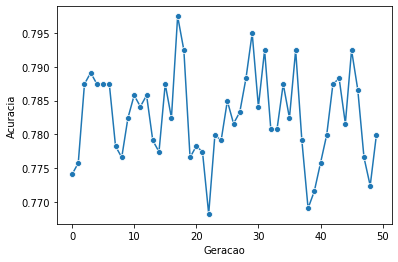

In [23]:
clf.fit(X_train.iloc[:,best_chromo[-1]],y_train)
predictions = clf.predict(X_test.iloc[:,best_chromo[-1]])
print("Accuracy score after genetic algorithm is= "+str(accuracy_score(y_test,predictions)))
sns.lineplot(data=plot, x="Geracao", y="Acuracia",  marker="o")

In [24]:
# def discrete_crossing(pop_after_sel, n_feat, scores):
#     population_nextgen=[]
#     cromossomo = []
#     # ao inves do range ser o tamanho da pop_after_sel, mudar para o tamanho desejado da população e pegar 2 pais aleatórios 
#     #a cada rodada igual tem na seleção
#     for i in range(len(pop_after_sel)):
#         dadIndex = random.randint(0,len(pop_after_sel)-1)
#         momIndex = random.randint(0,len(pop_after_sel)-1)
#         while(dadIndex == momIndex):
#             dadIndex = random.randint(0,len(pop_after_sel)-1)
#             momIndex = random.randint(0,len(pop_after_sel)-1)
#         dad = pop_after_sel[dadIndex]
#         mom = pop_after_sel[momIndex]
#         dadScore = scores[dadIndex]
#         momScore = scores[momIndex]
#         if dadScore > momScore:
#             best = dad
#             worst = mom
#         else:
#             best = mom
#             worst = dad
#         proba = 0.5
#         cromossomo.clear()
#         for k in range(n_feat):
#             p = random.uniform(0, 1) # 0 pai; 1 mãe
#             if p <= proba:
#                 cromossomo.append(worst[k])
#                 proba += 0.1
#             elif p > proba:
#                 cromossomo.append(best[k])
#                 proba -= 0.1
#         if (1 not in cromossomo):
#             cromossomo[random.randint(0, n_feat-1)] == True # trata o caso de gerar um filho com todas as colunas = False, pois isso impossibilitaria o treinamento       
#         population_nextgen.append(cromossomo)
#         population_nextgen.append(list((not gene for gene in cromossomo)))
#     return population_nextgen